#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

#import seaborn as sns
#from graphviz import Source

Using TensorFlow backend.


In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

#### parameters to set

In [3]:
# fix random seed for reproducibility
np.random.seed(17)

n_series = 5
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 2 * 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
refh = 12
subh = 1
chance = refh/(subh+refh)
cut = chance + (1-chance) * 0.05
print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

epochs=60

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate normal data

In [4]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(10, 80), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['score']=0.5
df.index = dti
#df.head()

#### generate anomalies

In [5]:
def random_anomalies():
    to_generate = int(n_timesteps * p_anomaly)
    for a in range(to_generate):
        affects = random.sample(range(n_series), random.randint(1, n_series))
        duration = int(max_anomaly_duration * random.random())
        start = int(n_timesteps * random.random())
        end = min(start+duration, n_timesteps)
        print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
        for s in affects:
            df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
        df.iloc[start:end,n_series]=1

def fixed_anomalies():
    for a in range(n_series):
        duration = 3600
        start = (a+1) * refh * 3600
        end = min(start+duration, n_timesteps)
        print('affected:', a+1, df.iloc[start].name, df.iloc[end].name)
        for s in range(a+1):
            df.iloc[start:end,s] = df.iloc[start:end,s] + 0.2
        df.iloc[start:end,n_series]=1
        
random_anomalies()

affected: [3, 1, 4, 0, 2] 2017-08-06 17:32:16 2017-08-06 20:53:55
affected: [1, 0] 2017-08-02 00:24:31 2017-08-02 03:10:56
affected: [1, 2] 2017-08-03 19:41:47 2017-08-03 22:51:14
affected: [0, 4, 2, 1] 2017-08-07 17:30:12 2017-08-07 19:59:21
affected: [1, 4] 2017-08-04 12:04:02 2017-08-04 13:09:56
affected: [1, 0, 2, 4, 3] 2017-08-01 23:13:19 2017-08-02 00:51:20
affected: [1] 2017-08-03 06:10:16 2017-08-03 07:34:23
affected: [3] 2017-08-02 11:32:47 2017-08-02 14:58:20
affected: [3, 2, 4, 0, 1] 2017-08-05 07:26:08 2017-08-05 07:34:17
affected: [0, 2, 4, 1] 2017-08-01 08:07:50 2017-08-01 09:45:12
affected: [0, 3, 2] 2017-08-07 18:29:47 2017-08-07 19:52:09
affected: [1, 3, 2, 4, 0] 2017-08-01 16:40:49 2017-08-01 16:45:35


#### enforce range

In [6]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

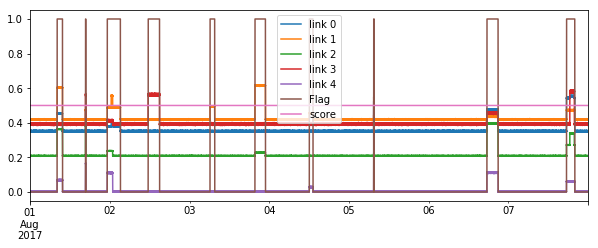

In [7]:
df.plot(figsize=(10,3.5))

#### create NN

In [8]:
def getModel():
    with tf.device('/gpu:1'):
        model = Sequential()
        model.add(Dense(units=n_series*2, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
        model.add(Dense(units=n_series*2, activation='relu'))    
#         model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid') )# 
        
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
        model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### functions

In [9]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['Flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['Flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

0
13440/14040 [===========================>..] - ETA: 0s
 2017-08-01 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.14957642555237
1
13440/14040 [===========================>..] - ETA: 0s
 2017-08-01 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.45168399810791
2
13120/14040 [===========================>..] - ETA: 0s
 2017-08-01 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.51423215866089
3
13920/14040 [============================>.] - ETA: 0s
 2017-08-01 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 34.85094714164734
4
13024/14040 [==========================>...] - ETA: 0s

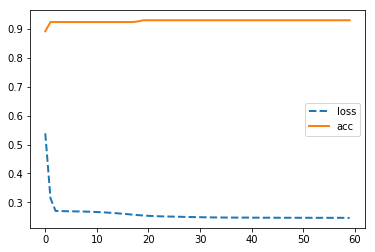


 2017-08-01 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.928846153846
took: 36.08630847930908
5
13792/14040 [============================>.] - ETA: 0s
 2017-08-01 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 34.69275188446045
6
13728/14040 [============================>.] - ETA: 0s
 2017-08-01 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.19259285926819
7
13696/14040 [============================>.] - ETA: 0s
 2017-08-01 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 34.93499732017517
8
14016/14040 [============================>.] - ETA: 0s
 2017-08-01 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 36.24493074417114
9
13696/14040 [============================>.] - ETA: 0s
 2017-08-01 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.53245735168457
10
13376/14040 [===========================>..] - ETA: 0s
 2017-08-01 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.9230769

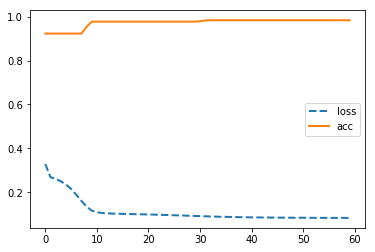


 2017-08-02 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.980982906017
took: 35.3441264629364
12
13792/14040 [============================>.] - ETA: 0s

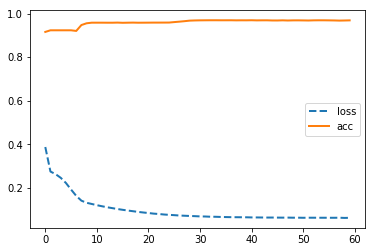


 2017-08-02 01:00:00 	refes: 43200 	subjects: 3600 	score: 0.96566951567
took: 35.355432748794556
13
13408/14040 [===========================>..] - ETA: 0s

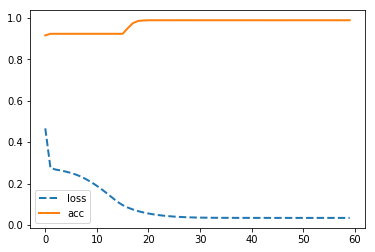


 2017-08-02 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.989886039886
took: 35.207175731658936
14
13344/14040 [===========================>..] - ETA: 0s
 2017-08-02 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.922863247863
took: 35.678337812423706
15
13376/14040 [===========================>..] - ETA: 0s
 2017-08-02 04:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.45976185798645
16
13504/14040 [===========================>..] - ETA: 0s
 2017-08-02 05:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.679779052734375
17
13312/14040 [===========================>..] - ETA: 0s
 2017-08-02 06:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 35.90338325500488
18
13600/14040 [============================>.] - ETA: 0s
 2017-08-02 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 36.7013201713562
19
13280/14040 [===========================>..] - ETA: 0s
 2017-08-02 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.

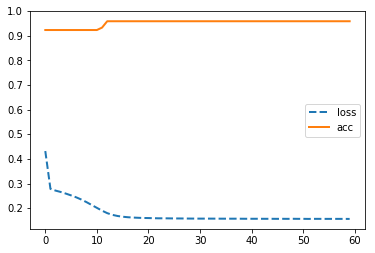


 2017-08-02 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.956267806302
took: 37.23841738700867
24
14040/14040 [==============================] - 0s     


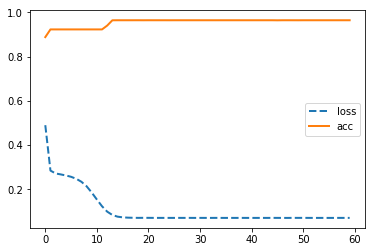


 2017-08-02 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.966381766382
took: 37.27598977088928
25
13824/14040 [============================>.] - ETA: 0s
 2017-08-02 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 36.80257320404053
26
13728/14040 [============================>.] - ETA: 0s
 2017-08-02 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.235021352767944
27
13760/14040 [============================>.] - ETA: 0s
 2017-08-02 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.3924765586853
28
13536/14040 [===========================>..] - ETA: 0s
 2017-08-02 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.393757343292236
29
13888/14040 [============================>.] - ETA: 0s
 2017-08-02 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.57456159591675
30
13280/14040 [===========================>..] - ETA: 0s
 2017-08-02 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.9

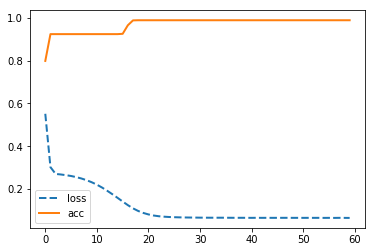


 2017-08-03 07:00:00 	refes: 43200 	subjects: 3600 	score: 0.984544159612
took: 38.68305420875549
43
13408/14040 [===========================>..] - ETA: 0s
 2017-08-03 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.48324179649353
44
13184/14040 [===========================>..] - ETA: 0s
 2017-08-03 09:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.161961793899536
45
13248/14040 [===========================>..] - ETA: 0s
 2017-08-03 10:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.54639387130737
46
13216/14040 [===========================>..] - ETA: 0s
 2017-08-03 11:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.80576467514038
47
13120/14040 [===========================>..] - ETA: 0s
 2017-08-03 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.96607828140259
48
14016/14040 [============================>.] - ETA: 0s
 2017-08-03 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.9

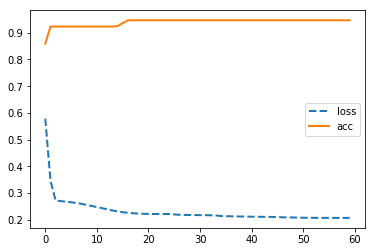


 2017-08-03 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.945868945903
took: 36.02818775177002
56
13920/14040 [============================>.] - ETA: 0s

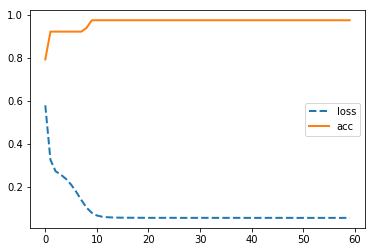


 2017-08-03 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.977991452991
took: 37.95411133766174
57
13568/14040 [===========================>..] - ETA: 0s
 2017-08-03 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 40.946985960006714
58
13408/14040 [===========================>..] - ETA: 0s
 2017-08-03 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.00857853889465
59
13216/14040 [===========================>..] - ETA: 0s
 2017-08-04 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.1274049282074
60
13888/14040 [============================>.] - ETA: 0s
 2017-08-04 01:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.455169677734375
61
13536/14040 [===========================>..] - ETA: 0s
 2017-08-04 02:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 39.99137020111084
62
13376/14040 [===========================>..] - ETA: 0s
 2017-08-04 03:00:00 	refes: 43200 	subjects: 3600 	score: 0.9

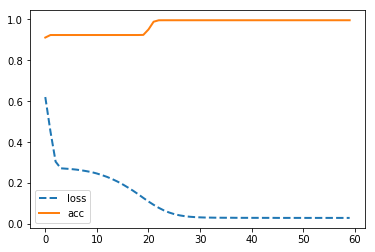


 2017-08-04 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.994017094085
took: 39.85305833816528
73
13984/14040 [============================>.] - ETA: 0s
 2017-08-04 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 39.168341398239136
74
13408/14040 [===========================>..] - ETA: 0s
 2017-08-04 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.401803970336914
75
13184/14040 [===========================>..] - ETA: 0s
 2017-08-04 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.077231884002686
76
13728/14040 [============================>.] - ETA: 0s
 2017-08-04 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.64861869812012
77
13248/14040 [===========================>..] - ETA: 0s
 2017-08-04 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.72998237609863
78
13280/14040 [===========================>..] - ETA: 0s
 2017-08-04 19:00:00 	refes: 43200 	subjects: 3600 	score: 0

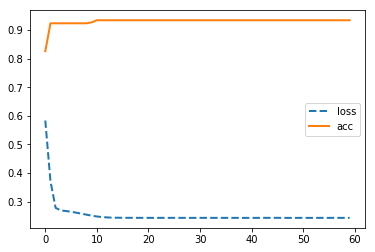


 2017-08-05 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.933048433048
took: 41.97266936302185
92
13920/14040 [============================>.] - ETA: 0s
 2017-08-05 09:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.519946336746216
93
13696/14040 [============================>.] - ETA: 0s
 2017-08-05 10:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 39.45836281776428
94
13824/14040 [============================>.] - ETA: 0s
 2017-08-05 11:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 37.98332953453064
95
13632/14040 [============================>.] - ETA: 0s
 2017-08-05 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.11185550689697
96
13600/14040 [============================>.] - ETA: 0s
 2017-08-05 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 38.083736419677734
97
13344/14040 [===========================>..] - ETA: 0s
 2017-08-05 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.

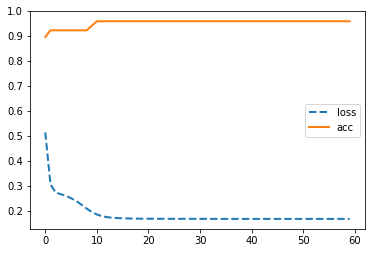


 2017-08-06 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.956908831943
took: 41.461000204086304
126
13376/14040 [===========================>..] - ETA: 0s

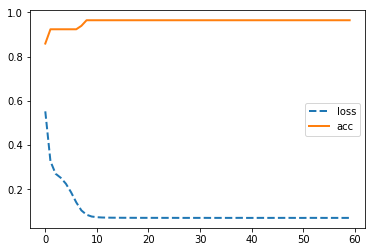


 2017-08-06 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.965811965812
took: 43.964335441589355
127
13440/14040 [===========================>..] - ETA: 0s
 2017-08-06 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 39.61483144760132
128
14040/14040 [==============================] - 1s     

 2017-08-06 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.266435623168945
129
14040/14040 [==============================] - 1s     

 2017-08-06 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.35945463180542
130
13888/14040 [============================>.] - ETA: 0s
 2017-08-06 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.48667359352112
131
13568/14040 [===========================>..] - ETA: 0s
 2017-08-07 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 41.50368928909302
132
13376/14040 [===========================>..] - ETA: 0s
 2017-08-07 01:00:00 	refes: 43200 	subjects: 3600 	s

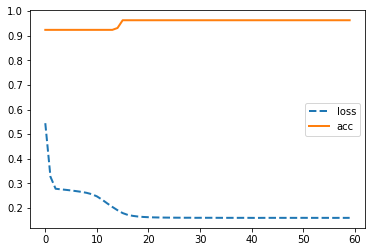


 2017-08-07 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.959401709436
took: 42.49784183502197
150
13472/14040 [===========================>..] - ETA: 0s

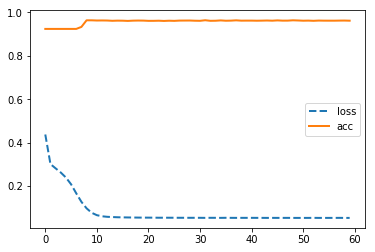


 2017-08-07 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.959900284934
took: 42.63190221786499
151
13440/14040 [===========================>..] - ETA: 0s

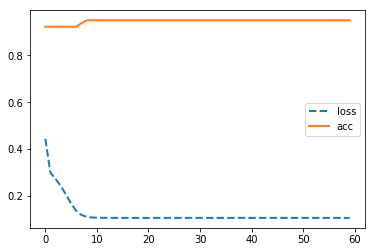


 2017-08-07 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.952706552774
took: 43.16611051559448
152
13568/14040 [===========================>..] - ETA: 0s
 2017-08-07 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 42.58020901679993
153
13440/14040 [===========================>..] - ETA: 0s
 2017-08-07 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 42.49336218833923
154
14016/14040 [============================>.] - ETA: 0s
 2017-08-07 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 42.521496057510376
155
13728/14040 [============================>.] - ETA: 0s
 2017-08-08 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 42.662715673446655


In [10]:
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


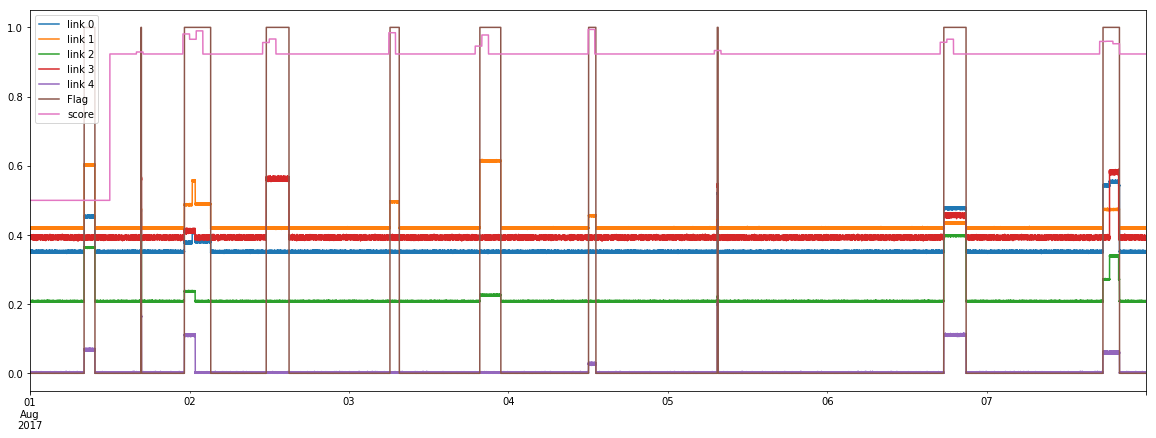

In [11]:
df.plot(figsize=(20,7))


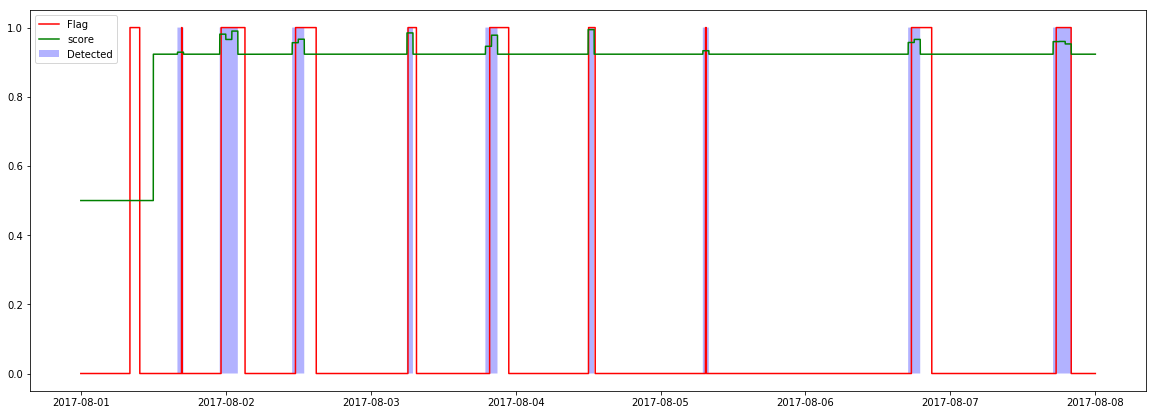

In [12]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()